# Prophet forecasting model

### Use Case: Forecast demand for seasonal medicines (e.g., cough syrups in winter, allergy medicines in spring).

In [62]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
from datetime import datetime, timedelta
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json, model_from_json
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [64]:
# Set plotting style
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

In [65]:
df = pd.read_csv('C:/Users/Admin/IIS/Data/Synthetic/Training/prophet_data.csv', parse_dates=['ds'])

In [66]:
df.sample(10)

,ds,y,product,month,day_of_year,is_winter,temp
3855,2023-10-23,14,Sunscreen,10,296,0,33.886745
4273,2022-01-14,21,Antihistamine,1,14,1,24.948981
1139,2022-03-16,44,Cough_Syrup,3,75,0,19.166012
599,2023-08-23,39,ORS_Solution,8,235,0,29.910915
52,2022-02-22,25,ORS_Solution,2,53,1,19.732900
4582,2022-11-19,15,Antihistamine,11,323,1,32.500847
3112,2024-09-09,45,Vitamin_C,9,253,0,30.010433
2446,2022-11-13,40,Vitamin_C,11,317,1,35.175941
3039,2024-06-28,25,Vitamin_C,6,180,0,22.879674
33,2022-02-03,20,ORS_Solution,2,34,1,21.700444


In [67]:
df['product'].value_counts()

product
ORS_Solution     1065
Cough_Syrup      1065
Vitamin_C        1065
Sunscreen        1065
Antihistamine    1065
Name: count, dtype: int64

In [68]:
df.shape

(5325, 7)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5325 entries, 0 to 5324
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ds           5325 non-null   datetime64[ns]
 1   y            5325 non-null   int64         
 2   product      5325 non-null   object        
 3   month        5325 non-null   int64         
 4   day_of_year  5325 non-null   int64         
 5   is_winter    5325 non-null   int64         
 6   temp         5325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 291.3+ KB


In [70]:
df['ds'] = pd.to_datetime(df['ds'])
df['y'] = df['y'].astype(float)

Performing EDA

In [99]:
def eda_product(df_product):
    product_name = df_product['product'].iloc[0].replace(' ','_').lower()
    
    # Daily sales
    plt.figure()
    plt.plot(df_product['ds'], df_product['y'], linewidth=0.8)
    plt.title(f'Daily Sales - {df_product["product"].iloc[0]}')
    plt.xlabel('Date'); plt.ylabel('Units Sold'); plt.tight_layout()
    
    # Rolling mean 30-day
    df_temp = df_product.set_index('ds')
    rolling = df_temp['y'].rolling(window=30).mean()
    plt.figure()
    plt.plot(df_temp.index, df_temp['y'], alpha=0.3, label='daily')
    plt.plot(rolling.index, rolling, color='red', label='30-day MA')
    plt.title(f'Rolling Mean 30-Day - {df_product["product"].iloc[0]}')
    plt.legend(); plt.tight_layout()
    
    # Monthly sum
    monthly = df_temp['y'].resample('M').sum()
    plt.figure()
    monthly.plot(kind='bar')
    plt.title(f'Monthly Sales - {df_product["product"].iloc[0]}')
    plt.tight_layout()
    
    # Weekly average
    weekly = df_temp['y'].resample('W').mean()
    plt.figure()
    weekly.plot()
    plt.title(f'Weekly Avg Sales - {df_product["product"].iloc[0]}')
    plt.tight_layout()
    
    df_temp.reset_index(inplace=True)


Train Prophet Model Function

In [120]:
def train_prophet(df_product, forecast_days=30): 
    """Trains Prophet on single product with regressors and returns model and forecast""" 
    
    prod_name = df_product['product'].iloc[0] 
    
    # Train until last available date (Nov 30 in your dataset)
    train_end = df_product['ds'].max()
    train_df = df_product.copy()
    
    # Prophet model 
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05
    ) 
    m.add_seasonality(name='monthly', period=30.4375, fourier_order=5) 
    m.add_regressor('is_winter') 
    m.add_regressor('temp') 
    m.fit(train_df[['ds','y','is_winter','temp']]) 
    
    # Forecast future (next forecast_days only)
    future = m.make_future_dataframe(periods=forecast_days, freq='D')
    future = future[future['ds'] > train_end].copy()   # keep only next 30 days
    
    # Add regressors
    future['month'] = future['ds'].dt.month 
    future['day_of_year'] = future['ds'].dt.dayofyear 
    future['is_winter'] = future['month'].isin([11,12,1,2]).astype(int) 
    future['temp'] = 25 + 8*np.sin(2*np.pi*(future['day_of_year']-200)/365) 
    
    forecast = m.predict(future[['ds','is_winter','temp']]) 
    
    # Save model 
    model_path = f'C:/Users/Admin/IIS/Models/Prophet/{prod_name.replace(" ","_")}_prophet.pkl' 
    joblib.dump(m, model_path) 
    
    # Standardized forecast table
    forecast_table = pd.DataFrame({
        "Date": forecast['ds'],
        "Product": prod_name,
        "Model": "Prophet",
        "Forecast": forecast['yhat'],
        "Actual": np.nan
    })
    
    return m, forecast_table


Loop Through Products & Combine Forecasts

C:\Users\Admin\AppData\Local\Temp\ipykernel_10892\1174872974.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_temp['y'].resample('M').sum()
20:40:38 - cmdstanpy - INFO - Chain [1] start processing
20:40:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_10892\1174872974.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_temp['y'].resample('M').sum()
20:40:39 - cmdstanpy - INFO - Chain [1] start processing
20:40:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_10892\1174872974.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_temp['y'].resample('M').sum()
20:40:40 - cmdstanpy - INFO - Chain [1] start processing
20:40:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Lo

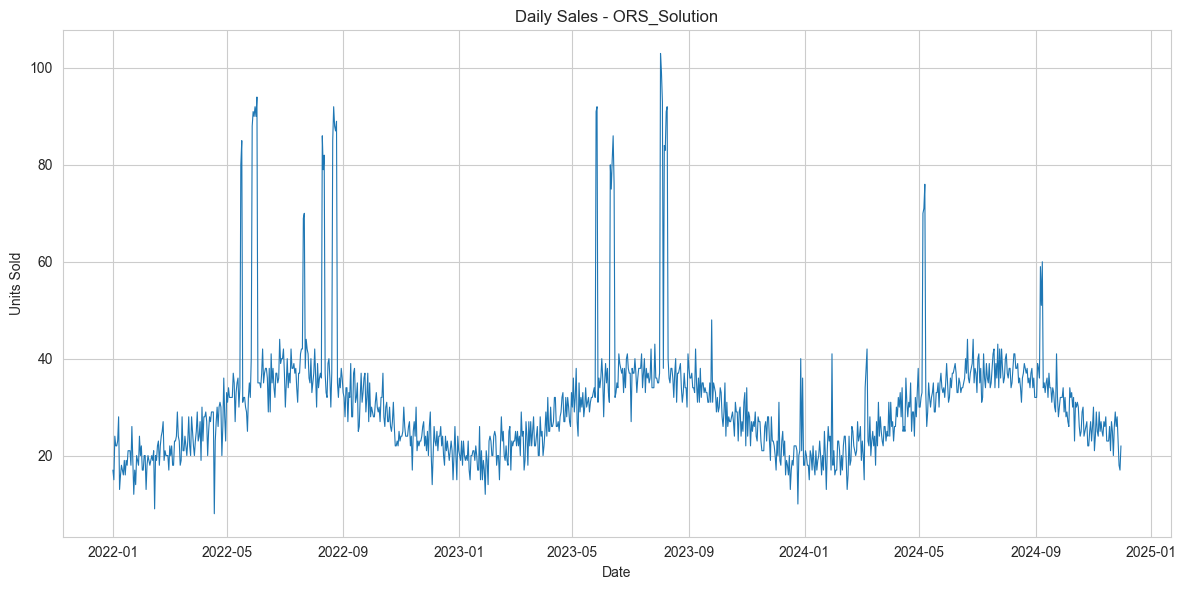

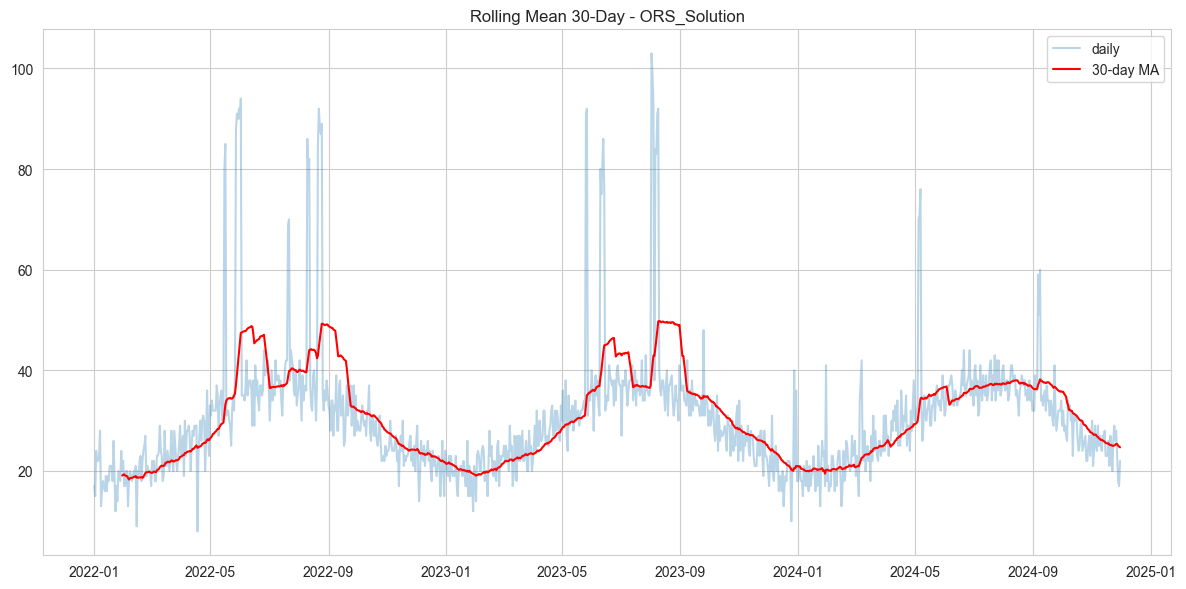

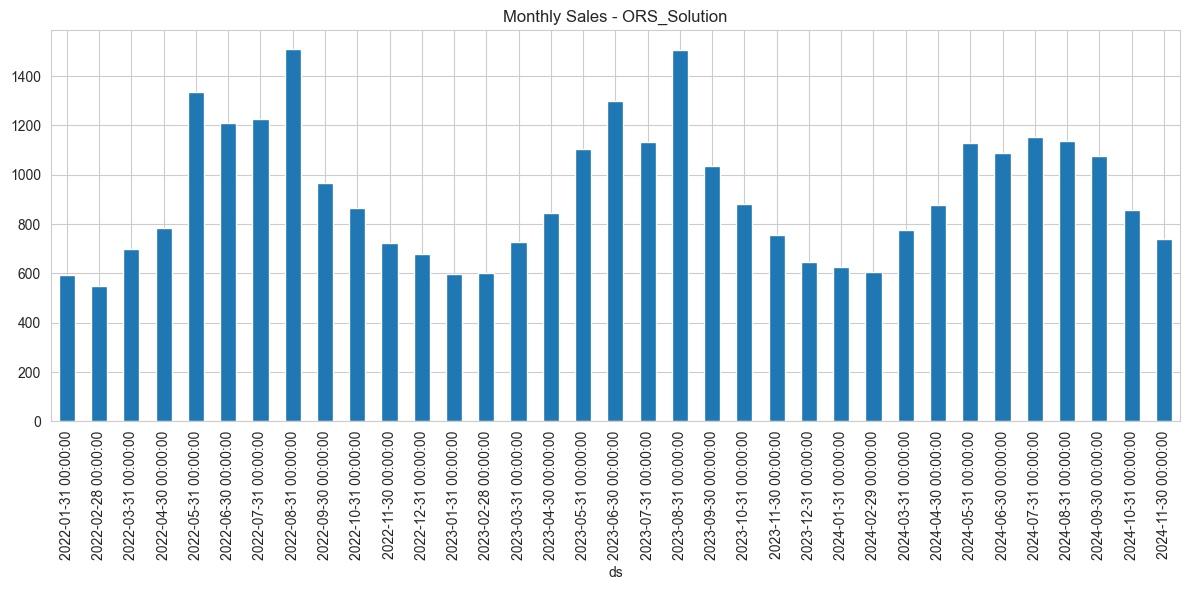

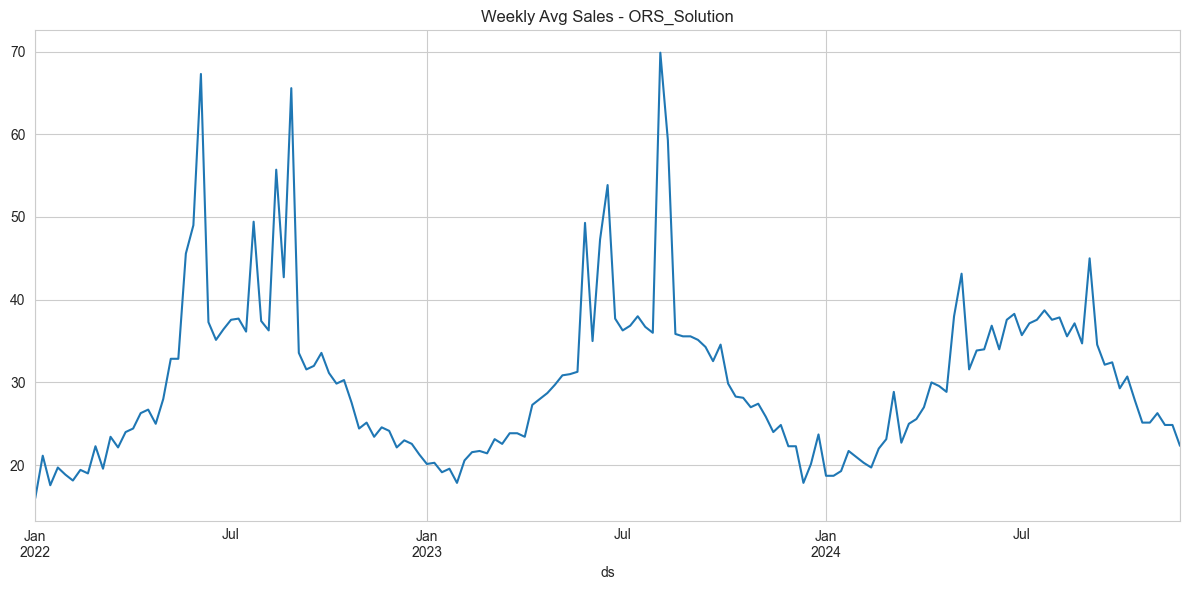

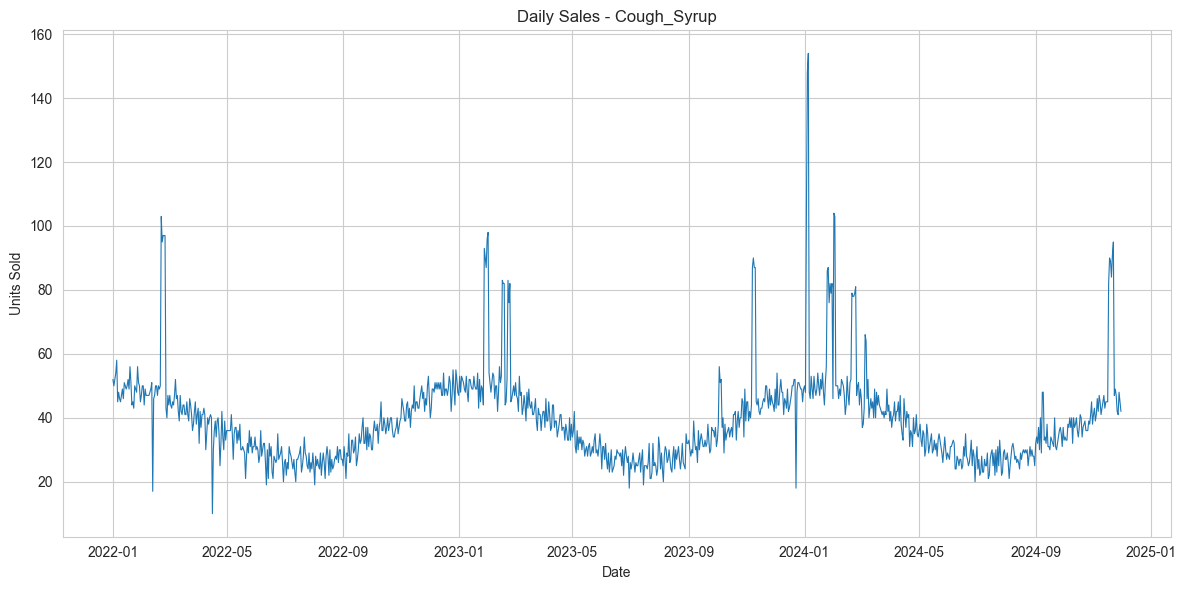

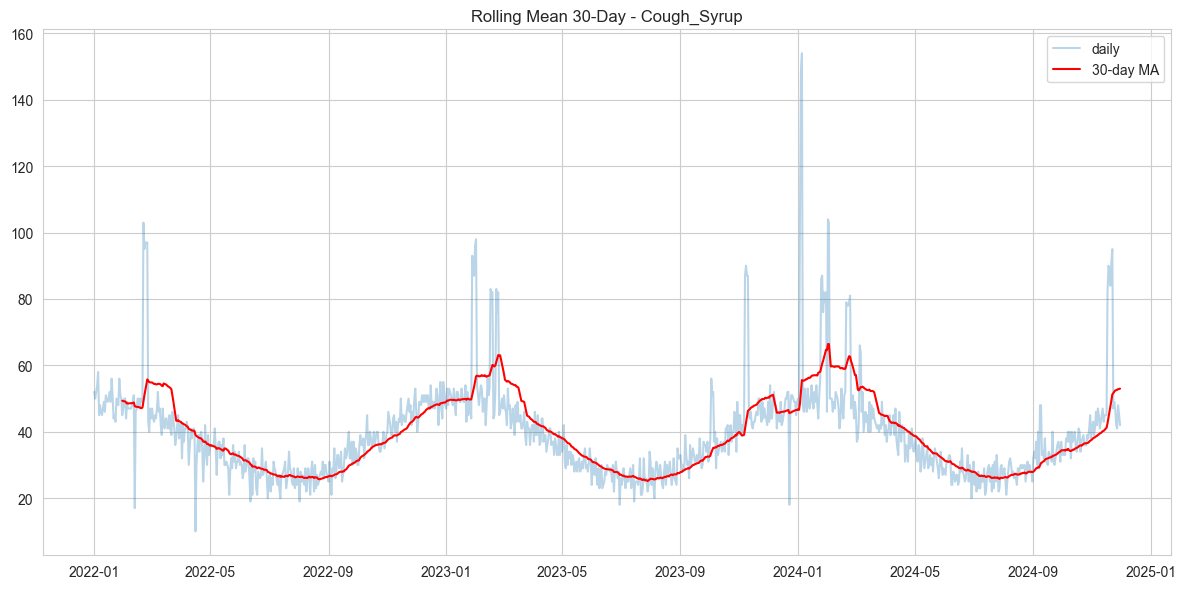

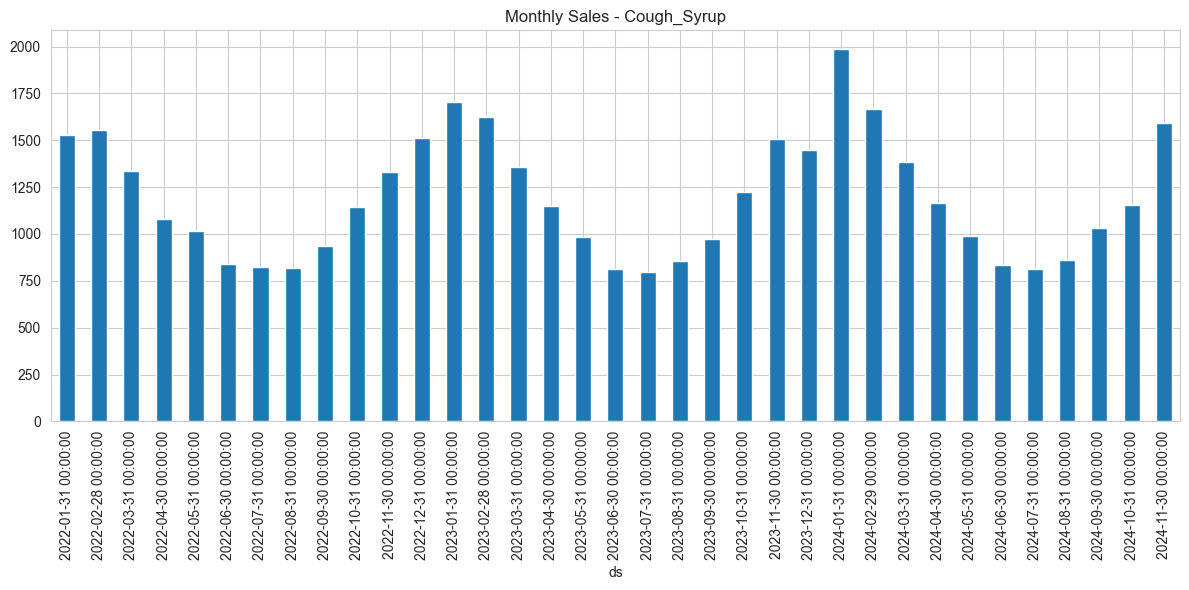

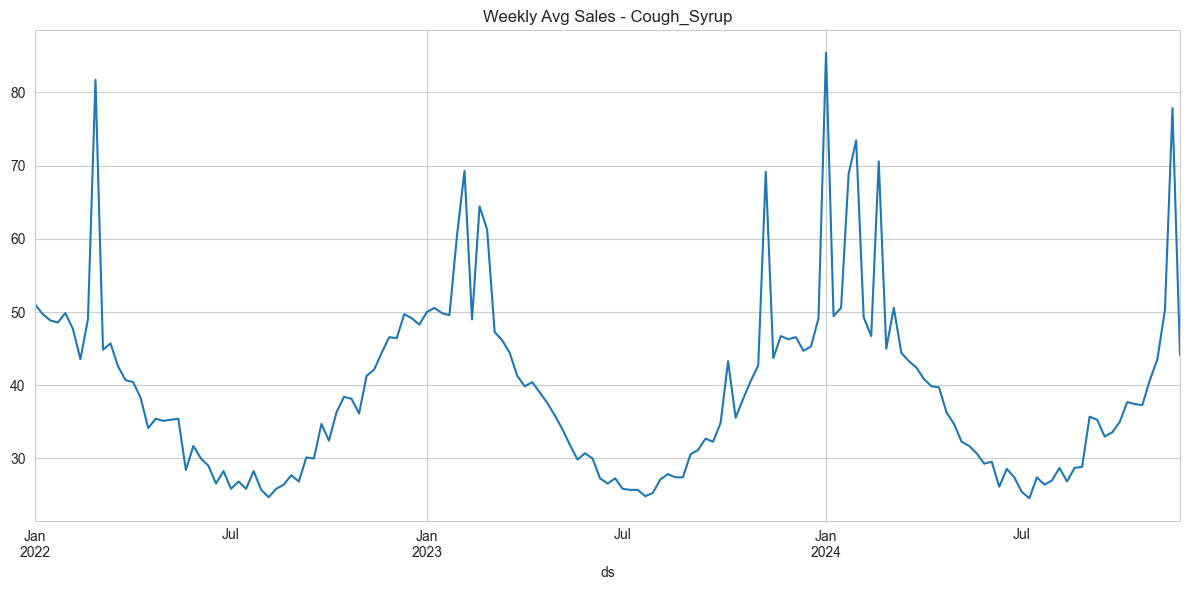

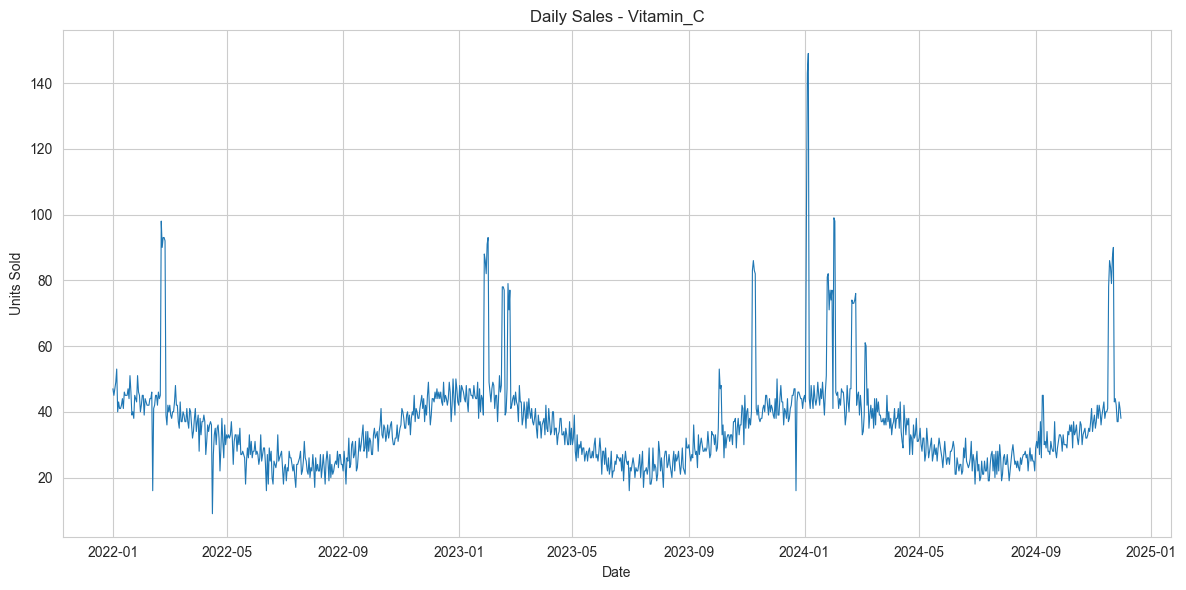

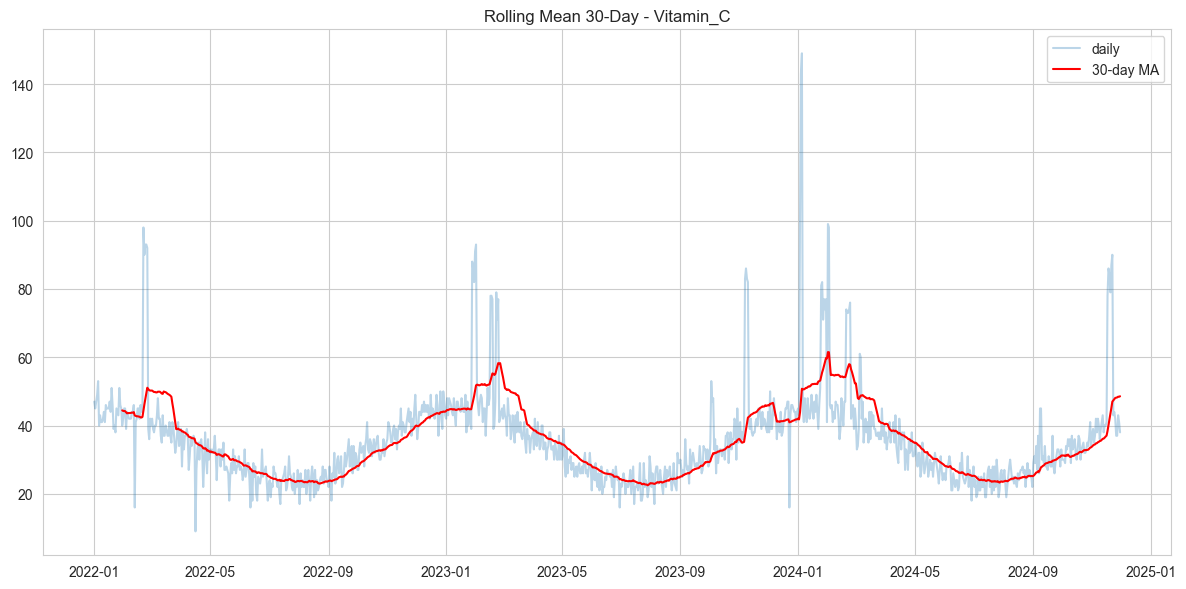

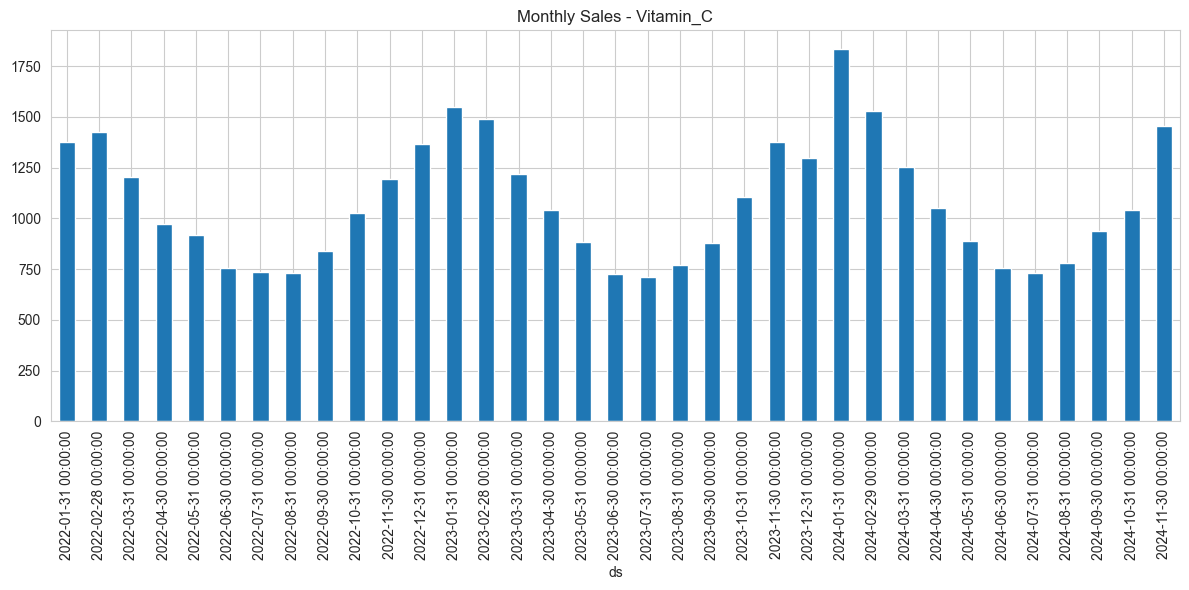

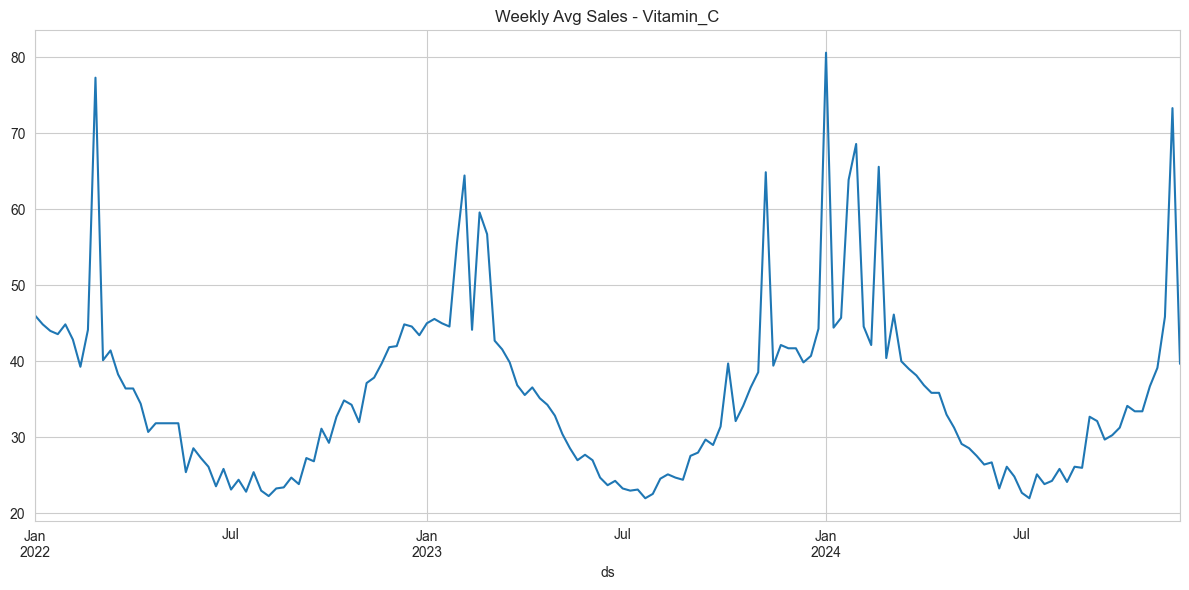

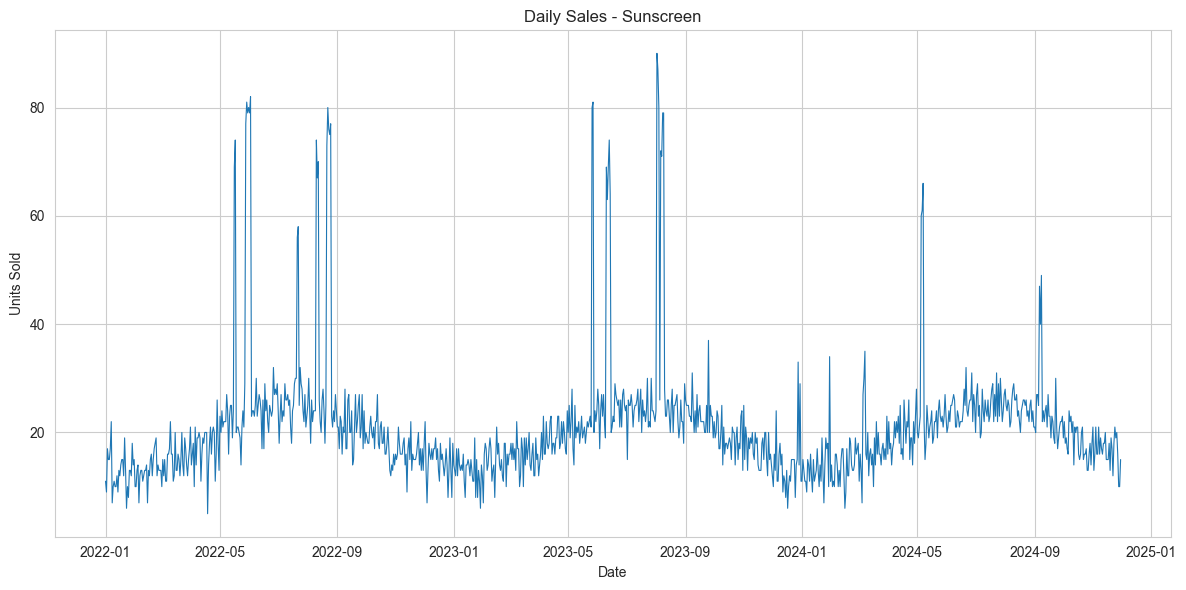

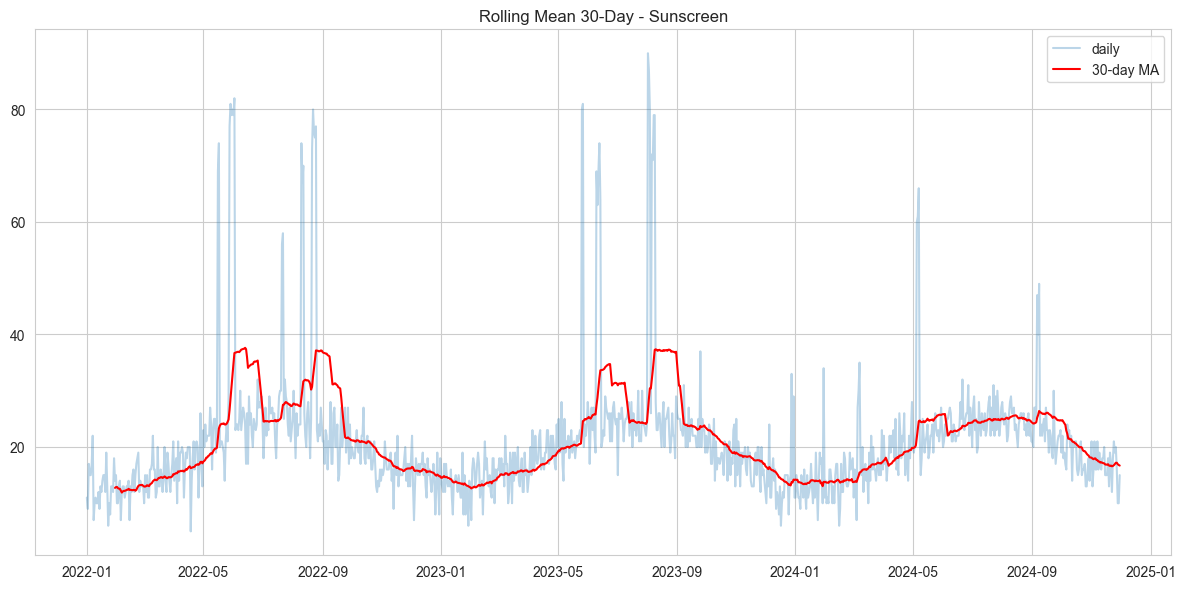

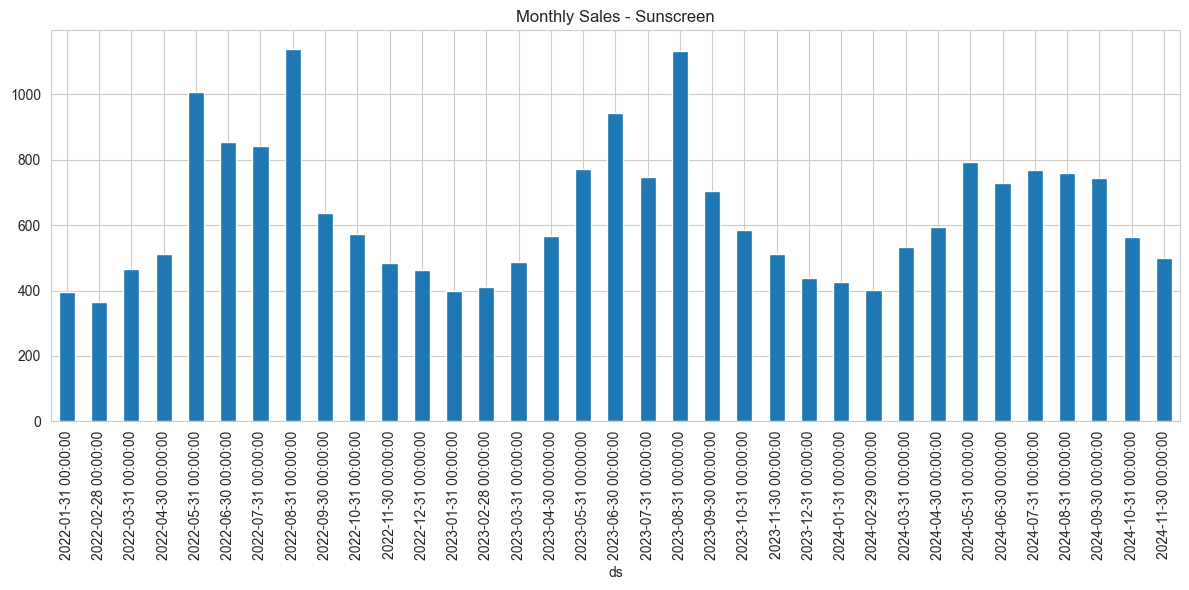

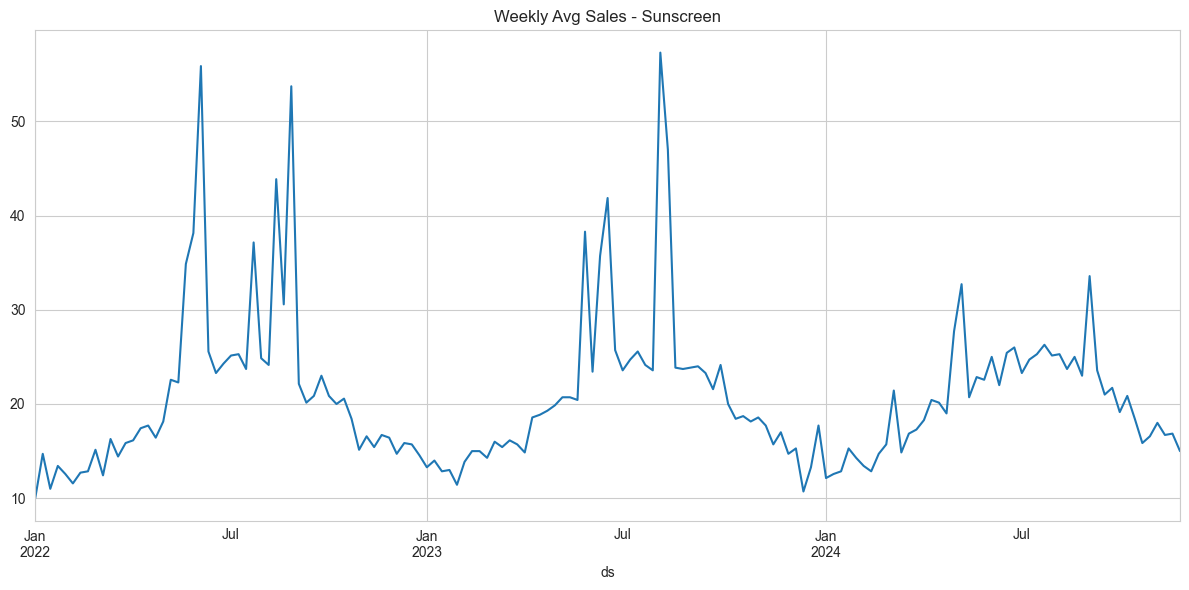

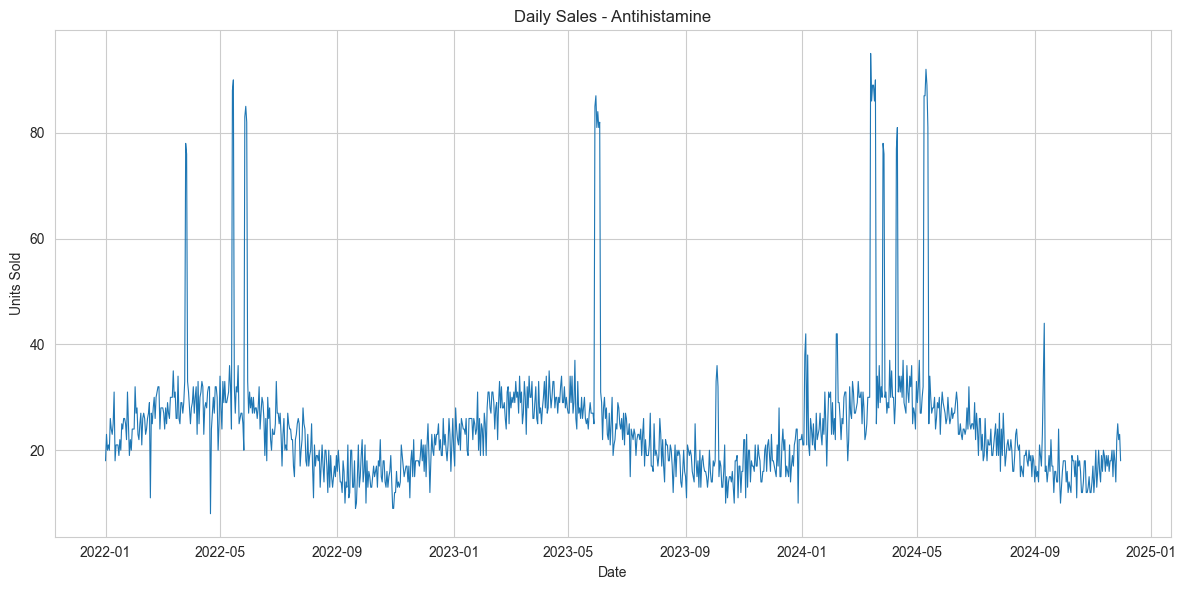

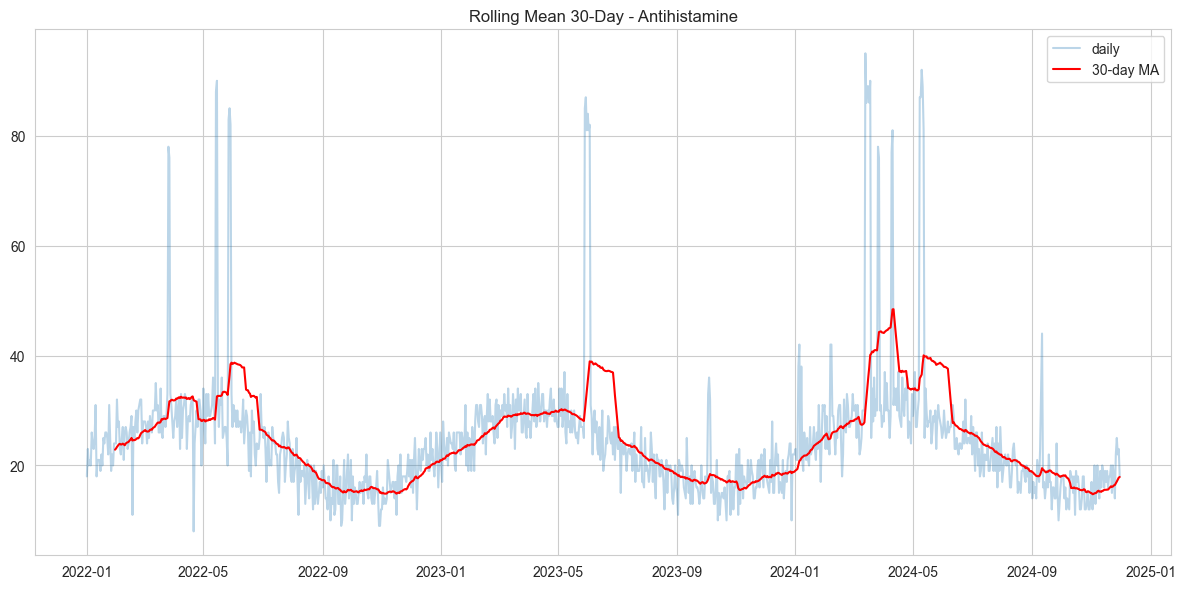

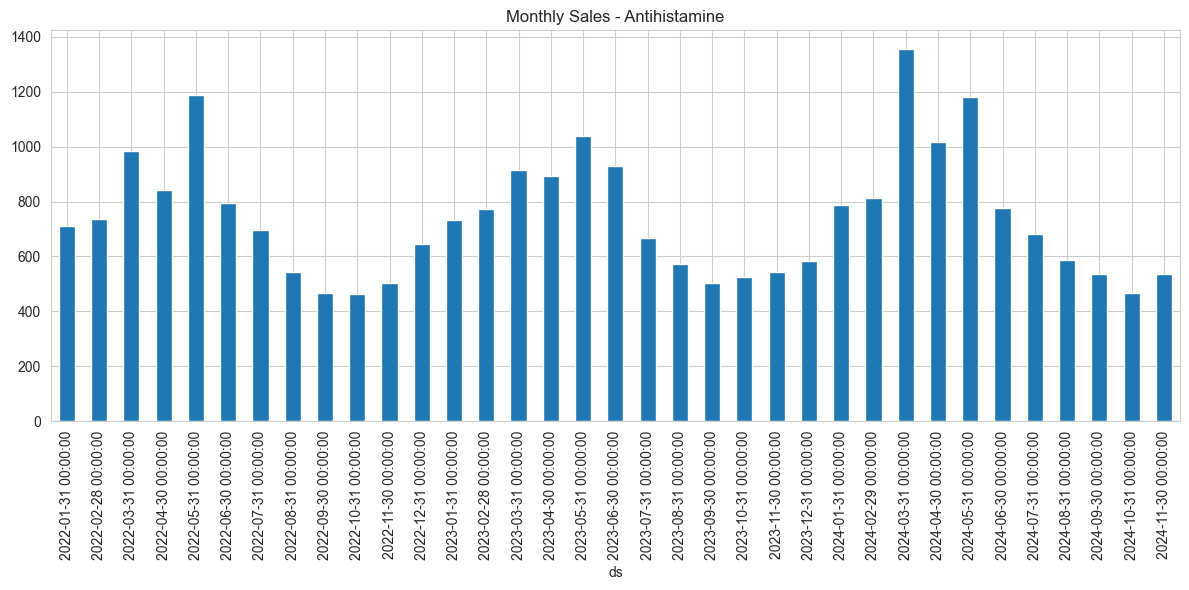

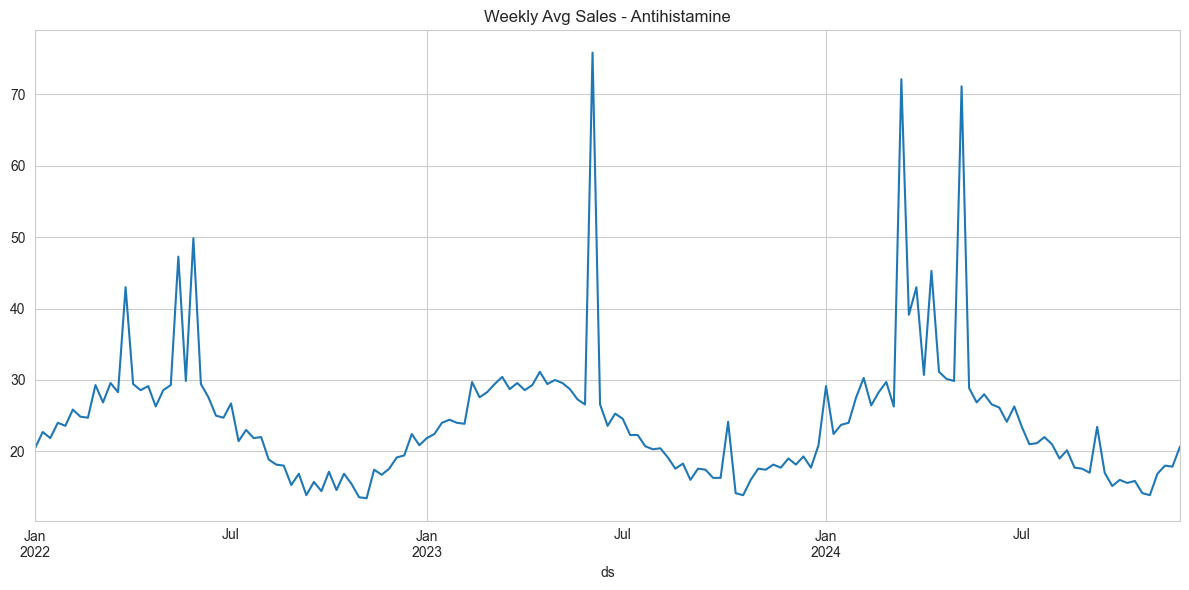

In [121]:
trained_models = {}
all_forecasts_list = []

products = ['ORS_Solution', 'Cough_Syrup', 'Vitamin_C', 'Sunscreen', 'Antihistamine']

for p in products:
    df_p = df[df['product'] == p].copy()
    eda_product(df_p)
    m, f = train_prophet(df_p, forecast_days=30)
    trained_models[p] = m
    all_forecasts_list.append(f)

forecast_all = pd.concat(all_forecasts_list, ignore_index=True)

In [122]:
# Combine all forecasts into single master table
master_forecast = pd.concat(all_forecasts_list, ignore_index=True)
#master_forecast.to_csv(f'C:/Users/Admin/IIS/Forecasts/Prophet/forecast_all_products.csv', index=False)

In [123]:
master_forecast.sample(10)

,Date,Product,Model,Forecast,Actual
22,2024-12-23,ORS_Solution,Prophet,19.677762,NaN
109,2024-12-20,Sunscreen,Prophet,11.437742,NaN
135,2024-12-16,Antihistamine,Prophet,18.859833,NaN
46,2024-12-17,Cough_Syrup,Prophet,50.270245,NaN
121,2024-12-02,Antihistamine,Prophet,19.751142,NaN
101,2024-12-12,Sunscreen,Prophet,12.404221,NaN
139,2024-12-20,Antihistamine,Prophet,19.350032,NaN
47,2024-12-18,Cough_Syrup,Prophet,51.271895,NaN
136,2024-12-17,Antihistamine,Prophet,19.056122,NaN
106,2024-12-17,Sunscreen,Prophet,10.821097,NaN


In [116]:
test_df=pd.read_csv("C:/Users/Admin/IIS/Data/Synthetic/Test/prophet_data.csv")

In [124]:
test_df.head()

,ds,y,product,month,day_of_year,is_winter,temp
0,2024-12-01,19,ORS_Solution,12,336,1,29.621745
1,2024-12-02,20,ORS_Solution,12,337,1,29.349987
2,2024-12-03,22,ORS_Solution,12,338,1,31.707077
3,2024-12-04,24,ORS_Solution,12,339,1,29.978486
4,2024-12-05,18,ORS_Solution,12,340,1,30.691015


In [125]:
# Convert forecast Date to datetime (if not already)
master_forecast['Date'] = pd.to_datetime(master_forecast['Date'])

# Convert actuals Date to datetime
test_df['ds'] = pd.to_datetime(test_df['ds'])

In [126]:
print(test_df['ds'].min(), test_df['ds'].max())
print(master_forecast['Date'].min(), master_forecast['Date'].max())

2024-12-01 00:00:00 2024-12-30 00:00:00
2024-12-01 00:00:00 2024-12-30 00:00:00


In [127]:
master_forecast['Product'] = master_forecast['Product'].str.strip()
test_df['product'] = test_df['product'].str.strip()
forecast_all.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      150 non-null    datetime64[ns]
 1   Product   150 non-null    object        
 2   Model     150 non-null    object        
 3   Forecast  150 non-null    float64       
 4   Actual    0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 6.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ds           150 non-null    datetime64[ns]
 1   y            150 non-null    int64         
 2   product      150 non-null    object        
 3   month        150 non-null    int64         
 4   day_of_year  150 non-null    int64         
 5   is_winter    150 non-null    int64         
 6   te

In [128]:
forecast_all = forecast_all.merge(test_df[['ds','product','y']], 
                                left_on=['Date','Product'],
                                right_on=['ds','product'],
                                how='left')
forecast_all['Actual'] = forecast_all['y']

In [131]:
forecast_all.sample(10)

,Date,Product,Model,Forecast,Actual,ds,product,y
128,2024-12-09,Antihistamine,Prophet,20.698376,18,2024-12-09,Antihistamine,18
126,2024-12-07,Antihistamine,Prophet,19.833770,20,2024-12-07,Antihistamine,20
5,2024-12-06,ORS_Solution,Prophet,21.191439,21,2024-12-06,ORS_Solution,21
148,2024-12-29,Antihistamine,Prophet,23.261299,24,2024-12-29,Antihistamine,24
29,2024-12-30,ORS_Solution,Prophet,19.821158,19,2024-12-30,ORS_Solution,19
53,2024-12-24,Cough_Syrup,Prophet,55.293853,53,2024-12-24,Cough_Syrup,53
62,2024-12-03,Vitamin_C,Prophet,45.509985,38,2024-12-03,Vitamin_C,38
32,2024-12-03,Cough_Syrup,Prophet,50.196731,43,2024-12-03,Cough_Syrup,43
7,2024-12-08,ORS_Solution,Prophet,20.590602,17,2024-12-08,ORS_Solution,17
98,2024-12-09,Sunscreen,Prophet,14.123242,17,2024-12-09,Sunscreen,17


In [132]:
forecast_all.drop(['product','y','ds'], axis=1, inplace=True)

In [133]:
forecast_all.sample(10)

,Date,Product,Model,Forecast,Actual
60,2024-12-01,Vitamin_C,Prophet,42.739192,41
94,2024-12-05,Sunscreen,Prophet,14.204004,10
29,2024-12-30,ORS_Solution,Prophet,19.821158,19
80,2024-12-21,Vitamin_C,Prophet,44.768220,39
46,2024-12-17,Cough_Syrup,Prophet,50.270245,50
92,2024-12-03,Sunscreen,Prophet,14.151918,15
17,2024-12-18,ORS_Solution,Prophet,17.911760,22
25,2024-12-26,ORS_Solution,Prophet,19.289988,24
84,2024-12-25,Vitamin_C,Prophet,50.447729,45
12,2024-12-13,ORS_Solution,Prophet,18.118946,24


In [134]:
forecast_file = os.path.join('C:/Users/Admin/IIS/Forecasts/Prophet', "prophet_forecast.csv")
forecast_all.to_csv(forecast_file, index=False)